In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import bm3d
import cv2
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
from scipy import ndimage as nd
from skimage.morphology import disk
from skimage.filters import median
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_nl_means)
from medpy.filter.smoothing import anisotropic_diffusion

In [29]:
import silence_tensorflow.auto
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from n2v.models import N2VConfig, N2V
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.utils import plot_history

In [3]:
ref_img = img_as_float(io.imread("Denoising/original_clean.tif", as_gray=True))
noisy_img = img_as_float(io.imread("Denoising/original_noisy.tif", as_gray=True))

In [4]:
# Gaussian Filter Denoising
gaussian_img = nd.gaussian_filter(noisy_img, sigma=4, mode='constant', cval=0.0)
noise_pnsr = peak_signal_noise_ratio(ref_img, noisy_img)
gaussian_pnsr = peak_signal_noise_ratio(ref_img, gaussian_img)

In [5]:
# Bilateral Filter Denoising
bilateral_img = denoise_bilateral(noisy_img, sigma_spatial=2, channel_axis=None)
bilateral_pnsr = peak_signal_noise_ratio(ref_img, bilateral_img)

In [6]:
# Total Variation Filter Denoising
tv_img = denoise_tv_chambolle(noisy_img, weight=0.4, channel_axis=None)
tv_pnsr = peak_signal_noise_ratio(ref_img, tv_img)

In [7]:
# Wavelet Denoising
wavelet_img = denoise_wavelet(noisy_img, mode='soft',method='VisuShrink', channel_axis=None)
wavelet_pnsr = peak_signal_noise_ratio(ref_img, wavelet_img)

In [8]:
# Anisotropic Diffusion
anisodiff_img = anisotropic_diffusion(noisy_img, niter=200, kappa=100, gamma=0.1, option=3)
anisodiff_pnsr = peak_signal_noise_ratio(ref_img, anisodiff_img)

/tmp/ipykernel_2177214/2127143341.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  anisodiff_pnsr = peak_signal_noise_ratio(ref_img, anisodiff_img)


In [9]:
# Non-local Means Denoising
sigma_est = np.mean(estimate_sigma(noisy_img, channel_axis=None))
NLM_img = denoise_nl_means(noisy_img, h=1.95 * sigma_est, fast_mode=True, patch_distance=10, patch_size=20, channel_axis=None)
NLM_pnsr = peak_signal_noise_ratio(ref_img, NLM_img)

In [10]:
# Block Matching and 3-d filtering
bm3d_img = bm3d.bm3d(noisy_img, sigma_psd=0.5, stage_arg=bm3d.BM3DStages.ALL_STAGES)
bm3d_pnsr = peak_signal_noise_ratio(ref_img, bm3d_img)

In [11]:
# Median Filter Denoising
median_img = median(noisy_img, disk(3), mode='constant', cval=0.0)
median_pnsr = peak_signal_noise_ratio(ref_img, median_img)

In [12]:
# Training autoencoder using MNIST dataset.
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [13]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

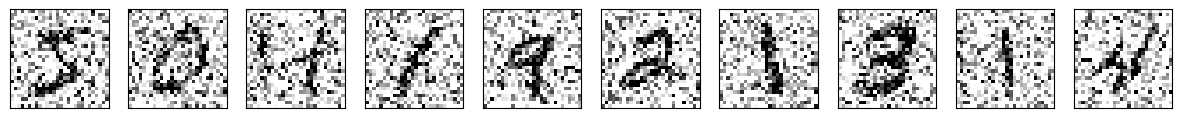

In [14]:
figure, axis = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
        axis[i].imshow(x_train_noisy[i].reshape(28,28),cmap="binary")
        axis[i].set_xticks([])
        axis[i].set_yticks([])

In [15]:
input_layer = tf.keras.Input(shape=(28, 28, 1))
layer1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
layer2 = tf.keras.layers.MaxPool2D((2, 2), padding = 'same')(layer1)
layer3 = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(layer2)
layer4 = tf.keras.layers.MaxPool2D((2, 2), padding = 'same')(layer3)
layer5 = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(layer4)
layer6 = tf.keras.layers.MaxPool2D((2, 2), padding = 'same')(layer5)

layer7 = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(layer6)
layer8 = tf.keras.layers.UpSampling2D((2, 2))(layer7)
layer9 = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(layer8)
layer10 = tf.keras.layers.UpSampling2D((2, 2))(layer9)
layer11 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(layer10)
layer12 = tf.keras.layers.UpSampling2D((2, 2))(layer11)
layer13 = tf.keras.layers.Conv2D(1, (3,3), activation='relu', padding='same')(layer12)

model = tf.keras.Model(input_layer, layer13)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,009 (27.38 KB)

 Trainable params: 7,009 (27.38 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    x_train_noisy,
    x_train,
    validation_data=(x_test_noisy, x_test),
    shuffle=True,
    batch_size=256,
    epochs=50,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=12,
    #         restore_best_weights=True
    #     )
    # ]
)


Epoch 1/50


I0000 00:00:1715272269.859959 2180130 service.cc:145] XLA service 0x72930c00d1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715272269.860117 2180130 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6


 25/235 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0913

I0000 00:00:1715272272.545252 2180130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0659 - val_loss: 0.0402
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0382 - val_loss: 0.0326
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0318 - val_loss: 0.0284
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0282 - val_loss: 0.0262
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0264 - val_loss: 0.0252
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0252 - val_loss: 0.0242
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0245 - val_loss: 0.0235
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0237 - val_loss: 0.0229
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0231 - val_loss: 0.0224
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0227 - val_loss: 0.0220
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0223 - val_loss: 0.0217
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


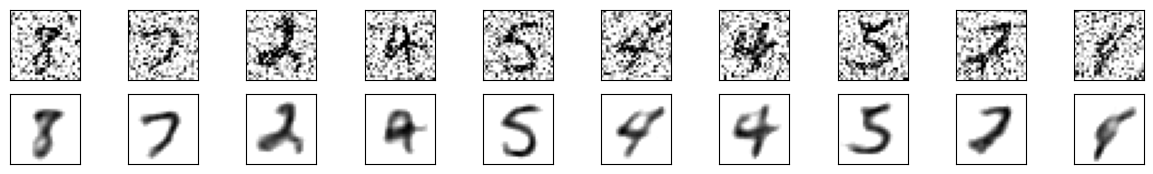

In [17]:
denoised_image = model.predict(x_test_noisy)

figure, axis = plt.subplots(2, 10, figsize=(15, 2))
for i in range(1):
    for j in range(10):
        ran = randint(10, 10000)
        axis[i,j].imshow(x_test_noisy[ran].reshape(28,28),cmap="binary")
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        axis[i+1,j].imshow(denoised_image[ran].reshape(28,28),cmap="binary")
        axis[i+1,j].set_xticks([])
        axis[i+1,j].set_yticks([])

In [50]:
# Predict the image using the trained model.
img = cv2.imread("Denoising/original_noisy.tif", 0)
noisy_img = img_to_array(img)
images= []

def denoise_large_image(model, img, patch_size=(28, 28), overlap=(6, 6)):
    height, width = img.shape[:2]
    denoised_image = np.zeros_like(img, dtype=np.float32)
    blend_mask = np.zeros_like(img, dtype=np.float32)
    stride_y, stride_x = patch_size[0] - overlap[0], patch_size[1] - overlap[1]

    for i in range(0, height - patch_size[0] + 1, stride_y):
        for j in range(0, width - patch_size[1] + 1, stride_x):
            patch = img[i:i+patch_size[0], j:j+patch_size[1]]
            if patch.shape[:2] == patch_size:
                patch = np.expand_dims(patch, axis=-1)
                denoised_patch = model.predict(np.expand_dims(patch, axis=0), verbose=0)
                denoised_patch = denoised_patch[0, :, :, 0]
                denoised_image[i:i+patch_size[0], j:j+patch_size[1]] += denoised_patch
                blend_mask[i:i+patch_size[0], j:j+patch_size[1]] += 1.0

    denoised_image /= blend_mask + 1e-6
    images.append(denoised_patch)

    return np.round(denoised_image).astype(np.uint8)

autoencoder_denoised_img = denoise_large_image(model, img)

In [51]:
# Using n2v
datagen = N2V_DataGenerator()
imgs = datagen.load_imgs_from_directory(directory = "Denoising/", filter='original_noisy.tif',dims='YXC')

# print(imgs[0].shape)

# imgs[0] = cv2.cvtColor(imgs[0][0], cv2.COLOR_BGR2GRAY) 
# imgs[0] = np.expand_dims(imgs[0], axis=0)
# imgs[0] = np.repeat(imgs[0][..., np.newaxis], 3, -1)
print(imgs[0].shape)
imgs[0] = imgs[0][...,:3]
imgs[0] = imgs[0]/255
patch_size = 64
patch_shape = patch_size, patch_size
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

(1, 1700, 1701, 3)
Generated patches: (5408, 64, 64, 3)


In [52]:
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]
print(X.shape)
print(X.dtype)
print(X_val.shape)

(4326, 64, 64, 3)
float32
(1082, 64, 64, 3)


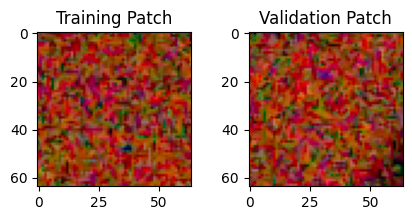

In [53]:
plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

In [57]:
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=150, train_loss='mse', 
                   batch_norm=True,train_checkpoint='best_weights.weights.h5',train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

vars(config)     

{'means': ['0.46858746', '0.3608144', '0.17334919'],
 'stds': ['0.21197845', '0.16985382', '0.15634967'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 150,
 'train_steps_per_epoch': 135,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'best_weights.weights.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [58]:
model_name = 'n2v_2D'
basedir = 'models'
model1 = N2V(config, model_name, basedir=basedir)

In [59]:
history = model1.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|█████████████████████████████████████████████████████████████████| 1082/1082 [00:00<00:00, 3863.26it/s]


Epoch 1/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.5660 - n2v_abs: 0.5622 - n2v_mse: 0.5660 - val_loss: 0.4839 - val_n2v_abs: 0.5590 - val_n2v_mse: 0.4839 - learning_rate: 4.0000e-04
Epoch 2/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.2459 - n2v_abs: 0.3719 - n2v_mse: 0.2459 - val_loss: 0.3412 - val_n2v_abs: 0.4522 - val_n2v_mse: 0.3412 - learning_rate: 4.0000e-04
Epoch 3/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.2132 - n2v_abs: 0.3446 - n2v_mse: 0.2132 - val_loss: 0.3236 - val_n2v_abs: 0.4248 - val_n2v_mse: 0.3236 - learning_rate: 4.0000e-04
Epoch 4/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.1974 - n2v_abs: 0.3287 - n2v_mse: 0.1974 - val_loss: 0.3504 - val_n2v_abs: 0.4360 - val_n2v_mse: 0.3504 - learning_rate: 4.0000e-04
Epoch 5/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.1831 - n2v_abs: 0.3160 - n2v_mse: 0.1831 - val_loss: 0.3548 - val_n2v_abs: 0.4355 - val_n2v_mse: 0.3548 - learning_rate: 4.0000e-04
Epoch 6/150
135

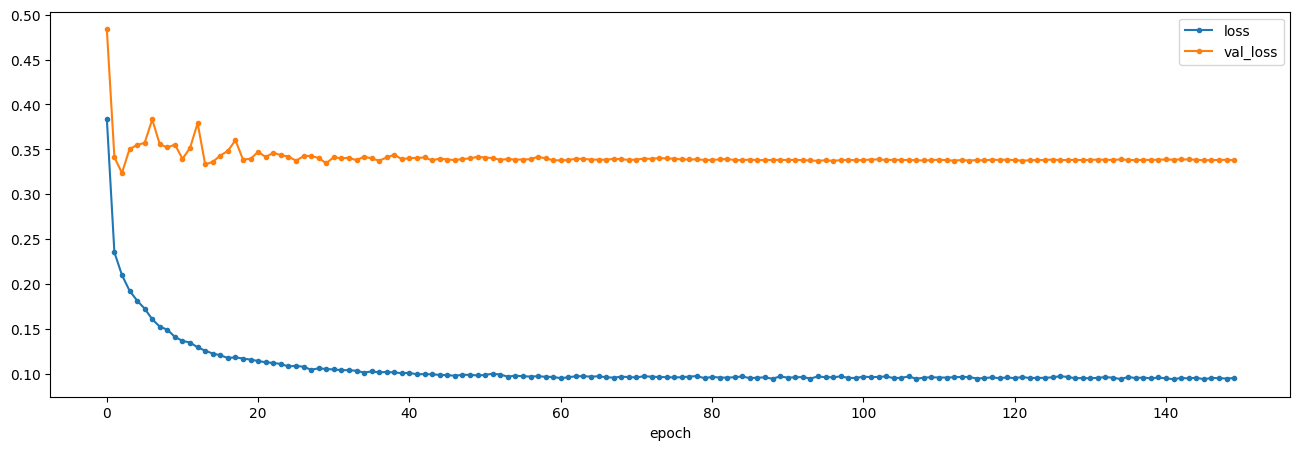

In [60]:
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [61]:
model_name = 'n2v_2D'
basedir = 'models'
model2 = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'best_weights.weights.h5'.


In [113]:
pred = model2.predict(noisy_img, axes='YXC', n_tiles=(4,4,1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.61it/s]


In [122]:
gray_pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

Text(0.5, -0.09, 'N2V denoised image')

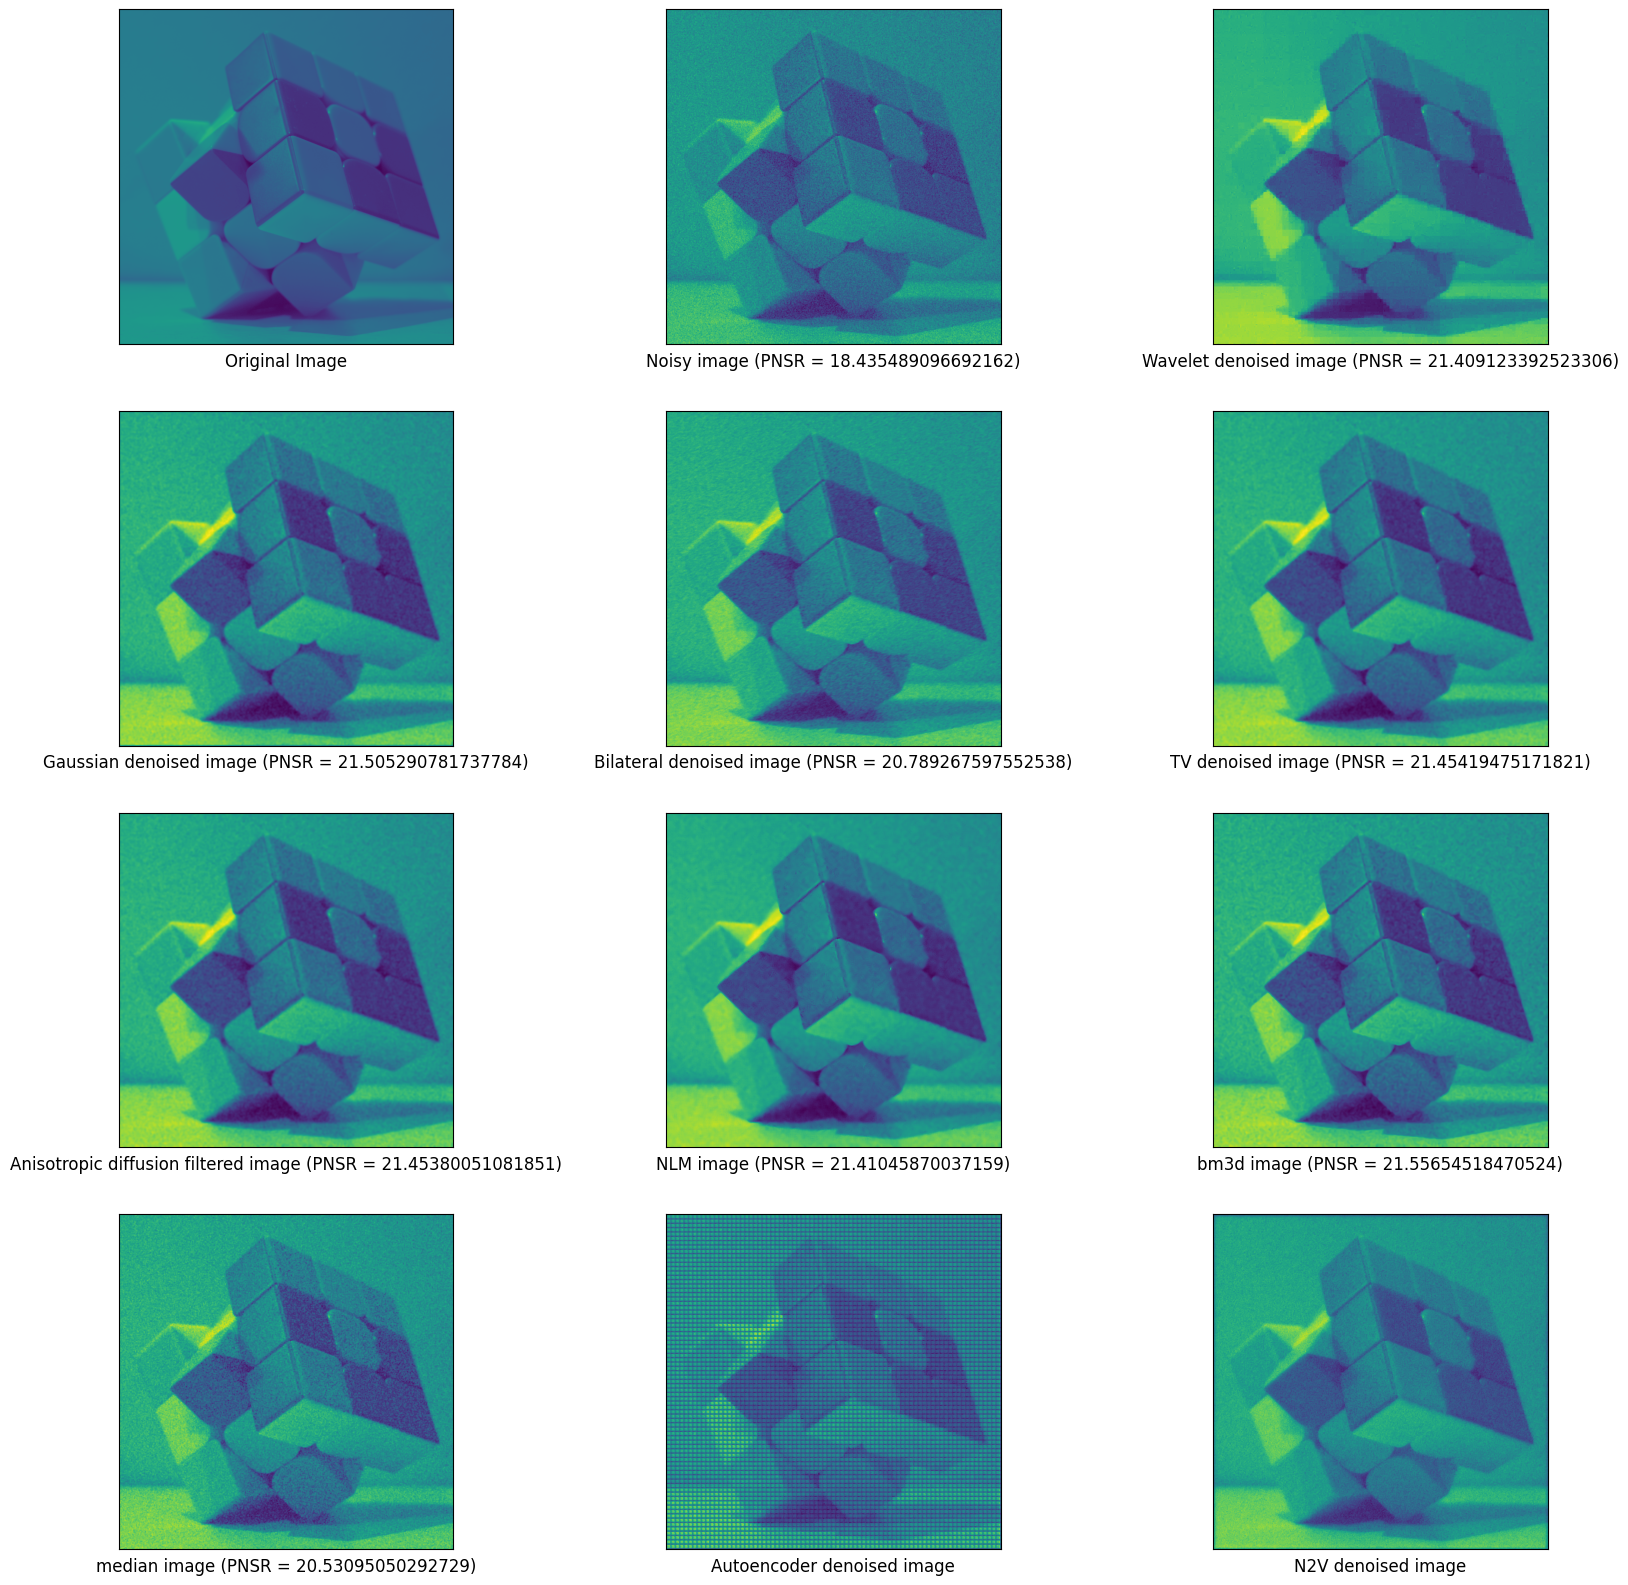

In [123]:
noise_title = "Noisy image (PNSR = {})".format(noise_pnsr)
gaussian_title = "Gaussian denoised image (PNSR = {})".format(gaussian_pnsr)
bilateral_title = "Bilateral denoised image (PNSR = {})".format(bilateral_pnsr)
tv_title = "TV denoised image (PNSR = {})".format(tv_pnsr)
wavelet_title = "Wavelet denoised image (PNSR = {})".format(wavelet_pnsr)
anisodiff_title = "Anisotropic diffusion filtered image (PNSR = {})".format(anisodiff_pnsr)
NLM_title = "NLM image (PNSR = {})".format(NLM_pnsr)
bm3d_title = "bm3d image (PNSR = {})".format(bm3d_pnsr)
median_title = "median image (PNSR = {})".format(median_pnsr)
encoder_title = "Autoencoder denoised image"
n2v_title = "N2V denoised image"

figure, axis = plt.subplots(4, 3, figsize=(20,20))
axis[0,0].imshow(ref_img)
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])
axis[0,0].set_title("Original Image", y=-0.09)

axis[0,1].imshow(noisy_img)
axis[0,1].set_xticks([])
axis[0,1].set_yticks([])
axis[0,1].set_title(noise_title, y=-0.09)

axis[0,2].imshow(wavelet_img)
axis[0,2].set_xticks([])
axis[0,2].set_yticks([])
axis[0,2].set_title(wavelet_title, y=-0.09)

axis[1,0].imshow(gaussian_img)
axis[1,0].set_xticks([])
axis[1,0].set_yticks([])
axis[1,0].set_title(gaussian_title, y=-0.09)

axis[1,1].imshow(bilateral_img)
axis[1,1].set_xticks([])
axis[1,1].set_yticks([])
axis[1,1].set_title(bilateral_title, y=-0.09)

axis[1,2].imshow(tv_img)
axis[1,2].set_xticks([])
axis[1,2].set_yticks([])
axis[1,2].set_title(tv_title, y=-0.09)

axis[2,0].imshow(anisodiff_img)
axis[2,0].set_xticks([])
axis[2,0].set_yticks([])
axis[2,0].set_title(anisodiff_title, y=-0.09)

axis[2,1].imshow(NLM_img)
axis[2,1].set_xticks([])
axis[2,1].set_yticks([])
axis[2,1].set_title(NLM_title, y=-0.09)

axis[2,2].imshow(bm3d_img)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])
axis[2,2].set_title(bm3d_title, y=-0.09)

axis[3,0].imshow(median_img)
axis[3,0].set_xticks([])
axis[3,0].set_yticks([])
axis[3,0].set_title(median_title, y=-0.09)

axis[3,1].imshow(autoencoder_denoised_img)
axis[3,1].set_xticks([])
axis[3,1].set_yticks([])
axis[3,1].set_title(encoder_title, y=-0.09)

axis[3,2].imshow(gray_pred)
axis[3,2].set_xticks([])
axis[3,2].set_yticks([])
axis[3,2].set_title(n2v_title, y=-0.09)